In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,BatchNormalization
from  keras import Sequential
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm.notebook import tqdm
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Context**

This is image data of Natural Scenes around the world.

**Content**

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

**Acknowledgements**

Thanks to https://datahack.analyticsvidhya.com for the challenge and Intel for the Data

Photo by Jan Böttinger on Unsplash

**Inspiration**

Want to build powerful Neural network that can classify these images with more accuracy.

In [6]:
# path 입력
train_dir = '../input/intel-image-classification/seg_train/seg_train/'
test_dir = '../input/intel-image-classification/seg_test/seg_test/'
pred_dir = '../input/intel-image-classification/seg_pred/seg_pred/'

In [7]:
#디렉토리 내부 살펴보기
os.listdir(train_dir)

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [8]:
album = pd.DataFrame(columns = ["id","label"])
dirs = ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
# 각 디렉토리당 사진 정렬
for direc in dirs:
    #print(direc)
    for file in tqdm(os.listdir(train_dir + direc)):
        album = album.append({"id":file,"label":direc},ignore_index = True)
album.head()

,id,label
0,14986.jpg,mountain
1,3138.jpg,mountain
2,1700.jpg,mountain
3,16257.jpg,mountain
4,2863.jpg,mountain


In [9]:
#각 항목의 데이터의 수
album['label'].value_counts()

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: label, dtype: int64

In [10]:
test_album = pd.DataFrame(columns = ["id","label"])
dirs = ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
# 테스트에 들어있는 사진 정렬
for direc in dirs:
    for file in os.listdir(test_dir + direc):
        test_album = test_album.append({"id":file,"label":direc},ignore_index = True)
test_album.head()

,id,label
0,22608.jpg,mountain
1,23274.jpg,mountain
2,23775.jpg,mountain
3,22046.jpg,mountain
4,23436.jpg,mountain


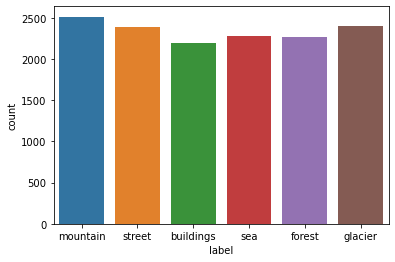

In [11]:
# train디고렉토리 내부 각 항목별 갯수 이미지화해서 확인
sns.countplot(x="label", data=album)

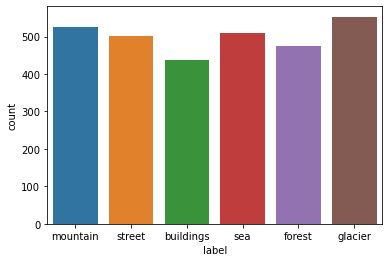

In [12]:
sns.countplot(x="label", data=test_album)

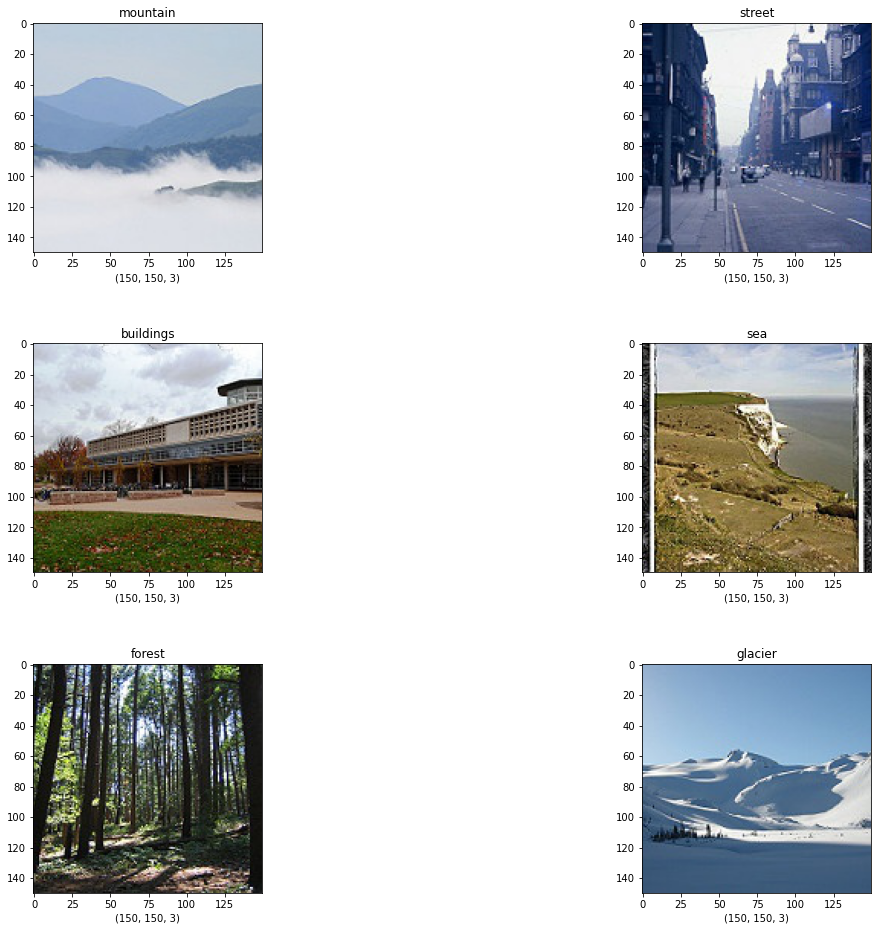

In [13]:
plt.figure(figsize = (20,16))
n = 0
# 항목들 이미지 보기
for label in dirs:
    n += 1
    # .where(a,b) : Replace values where the condition is False
    # a에는 조건을 넣어주고 그 조건이 안되는 값은 Nan값이 되거나 b로 값을 바꿈(b생략가능)
    # img는 (albun['id']에서 album['label']값이 lavel과 같지 않으면 Nan값이 됨 -> 난값은 dropna()으로 없어짐)의 0번째
    # 각 항목별로 하나씩만 가져오기 위해서
    img = (album["id"].where(album["label"] == label).dropna()).iloc[0]
    # 3열 2행으로 각자 1~6번째 자리로 순서대로 들어가게 된다
    plt.subplot(3,2,n)
    plt.subplots_adjust(hspace = 0.4,wspace = 0.2)
    path = train_dir + label + '/' + img
    plt.imshow(Image.open(path))
    # 파일의 가로,세로,채널 정보 기입
    plt.xlabel((img_to_array(Image.open(path))).shape)
    plt.title(label)
    
plt.show()

In [14]:
def generate(train_dir,test_dir):
    # train data data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,validation_split = 0.2)
    # test data에는 augmentation을 하면 안된다
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # train data 설정
    train_gen = train_datagen.flow_from_directory(
      directory = train_dir,
      subset="training",
      target_size = (150,150),
      shuffle = True,
      class_mode = 'categorical',
      batch_size=500)
    
    # validation data 설정
    val_gen = train_datagen.flow_from_directory(
      directory = train_dir,
      subset="validation",
      shuffle = True,
      class_mode = 'categorical',
      target_size=(150,150),
      batch_size=500)
    
    # test data 설정
    test_gen = test_datagen.flow_from_directory(
      directory = test_dir,
      shuffle = True,
      class_mode = 'categorical',
      target_size = (150,150),
      batch_size = 500)
    
    return train_gen,val_gen,test_gen

In [15]:
train_gen,valid_gen,test_gen = generate(train_dir,test_dir)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [16]:
# trans learning
from keras.applications import DenseNet121

In [17]:
# 모델을 어떻게 불러올 것인가
def get_model(arch):
    base_model = arch(include_top = False,
                        input_shape = (150,150,3),
                        weights = "imagenet")
    base_model.trainable = False
    print("Length of Model: ",len(list((base_model.layers))))
    return base_model

In [18]:
# 그래프를 보여주는 함수
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [19]:
# 레이어 구성하는 함수
def hypertune(train_gen,valid_gen,test_gen,arch = DenseNet121,lr = 0.005,m =128,n =512):    
    base_model = get_model(arch)
    gal = GlobalAveragePooling2D()(base_model.output)
    d1 = Dense(units = m,activation = 'relu')(gal)
    drop1 = Dropout(0.2)(d1)
    d2 = Dense(units = n,activation = 'relu')(drop1)
    drop2 = Dropout(0.4)(d2)
    bn = BatchNormalization()(drop2)
    output = Dense(units = 6,activation = "softmax")(bn)
    model = tf.keras.Model(inputs = base_model.input,outputs = output)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = lr),loss = "categorical_crossentropy",metrics = ["categorical_accuracy"])
    history = model.fit(train_gen,validation_data = valid_gen,batch_size = 500,steps_per_epoch = 11230 // 500,epochs = 5)
    loss,acc = model.evaluate(test_gen)
    return [model,history]

In [20]:
values = hypertune(train_gen,valid_gen,test_gen)
model = values[0]
history = values[1]

29089792/29084464 [==============================] - 0s 0us/step
Length of Model:  427
Epoch 1/5
22/22 [==============================] - 78s 4s/step - loss: 0.5849 - categorical_accuracy: 0.7954 - val_loss: 1.0127 - val_categorical_accuracy: 0.7643
Epoch 2/5
22/22 [==============================] - 25s 1s/step - loss: 0.3248 - categorical_accuracy: 0.8805 - val_loss: 0.4620 - val_categorical_accuracy: 0.8509
Epoch 3/5
22/22 [==============================] - 26s 1s/step - loss: 0.2805 - categorical_accuracy: 0.8942 - val_loss: 0.3042 - val_categorical_accuracy: 0.8919
Epoch 4/5
22/22 [==============================] - 25s 1s/step - loss: 0.2609 - categorical_accuracy: 0.9039 - val_loss: 0.2984 - val_categorical_accuracy: 0.8941
Epoch 5/5
6/6 [==============================] - 13s 2s/step - loss: 0.2491 - categorical_accuracy: 0.9133


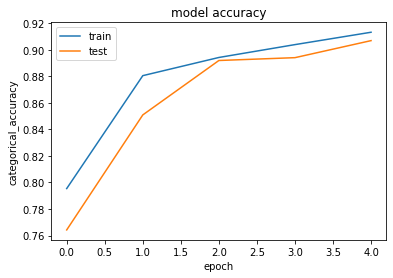

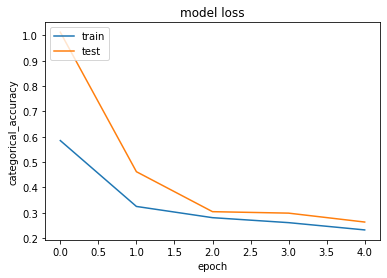

In [21]:
plot_history(history)

In [22]:
classes = list(train_gen.class_indices)
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [23]:
x = img_to_array(Image.open('../input/intel-image-classification/seg_train/seg_train/street/1000.jpg'))
x = x/255
x = np.expand_dims(x,axis = 0)
x.shape
print(classes[np.argmax(model.predict(x))])

street


In [24]:
pred_album = pd.DataFrame(columns = ["id","label"])

In [25]:
os.listdir(pred_dir)

['6234.jpg',
 '22288.jpg',
 '20529.jpg',
 '21440.jpg',
 '5982.jpg',
 '7737.jpg',
 '2081.jpg',
 '10054.jpg',
 '3919.jpg',
 '21838.jpg',
 '6399.jpg',
 '9960.jpg',
 '3757.jpg',
 '9131.jpg',
 '9062.jpg',
 '4489.jpg',
 '3417.jpg',
 '6074.jpg',
 '7894.jpg',
 '10305.jpg',
 '4407.jpg',
 '17720.jpg',
 '15979.jpg',
 '8983.jpg',
 '9697.jpg',
 '21590.jpg',
 '2628.jpg',
 '22604.jpg',
 '16202.jpg',
 '3363.jpg',
 '13333.jpg',
 '14395.jpg',
 '6943.jpg',
 '3228.jpg',
 '12132.jpg',
 '8075.jpg',
 '6365.jpg',
 '6459.jpg',
 '7690.jpg',
 '21966.jpg',
 '23566.jpg',
 '13087.jpg',
 '4772.jpg',
 '21145.jpg',
 '6925.jpg',
 '10201.jpg',
 '15764.jpg',
 '7918.jpg',
 '16401.jpg',
 '20789.jpg',
 '11617.jpg',
 '23258.jpg',
 '19651.jpg',
 '6800.jpg',
 '14376.jpg',
 '20321.jpg',
 '12267.jpg',
 '18227.jpg',
 '4765.jpg',
 '22270.jpg',
 '21588.jpg',
 '6209.jpg',
 '5068.jpg',
 '11529.jpg',
 '6229.jpg',
 '1749.jpg',
 '15360.jpg',
 '1995.jpg',
 '24068.jpg',
 '18048.jpg',
 '12334.jpg',
 '20429.jpg',
 '3537.jpg',
 '21946.jpg',


In [ ]:
for file in os.listdir(pred_dir):
    # 파일의 path설정
    path = pred_dir + file
    # img를 배열로 바꿔주고
    x = img_to_array(Image.open(path))
    x = x/255
    # np.expand_dims() : 차원을 추가
    x = np.expand_dims(x,axis = 0)
    # np.argmax() : 최댓값의 인덱스
    pred = classes[np.argmax(model.predict(x))]
    pred_album = pred_album.append({"id":file,"label":pred},ignore_index = True)

In [ ]:
pred_album.shape

In [ ]:
showcase = pred_album.iloc[:16,:]
plt.figure(figsize = (20,16))
n = 0
# zip() : 동일한 개수로 이루어진 자료형을 묶어 주는 역할을 하는 함수
for image,label in zip(list(showcase["id"]),list(showcase["label"])):
    n += 1
    plt.subplot(4,4,n)
    plt.subplots_adjust(hspace= 0.4,wspace = 0.4)
    path = pred_dir + image
    plt.imshow(Image.open(path))
    plt.title('{}'.format(label))

In [ ]:
# csv파일로 내보냄
pred_album.to_csv('answers.csv')

In [ ]:
for label in dirs:
    # 클래스별 첫번째 사진만 
    file = (album["id"].where(album["label"] == label).dropna()).iloc[0]
    path = train_dir + label + '/' + file
    sample_img = load_img(path, target_size=(150,150,3))
    plt.imshow(sample_img)
    sample_img = np.expand_dims(sample_img, axis=0)
    sample_img = tf.keras.applications.densenet.preprocess_input(sample_img)
    extractor = tf.keras.Model(inputs = model.input,outputs = model.layers[4].output)
    feature_maps = extractor.predict(sample_img)
    plt.figure(figsize = (20,16))
    n = 0
    for i in range(32):
        n += 1
        plt.subplot(8,4,n)
        plt.subplots_adjust()
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, n-1], cmap='gray')
        # show the figure
    plt.show()